### Exploring tweets aimed at @HeathrowAirport: Can it predict queues?



#### What might a model look like? A regression based on Bayes rule, with these coefficients:
Total keywords in last X hours\
Total keywords\
Total tweets in last X hours\
Sentiment\
Time of day\
Intercept

And perhaps some weighting system which gives more weight to more recent tweets, and/or those with more retweets

Sentiment doesn't appear to be at all correlated with keywords associated with waiting (good for regression)

Target variable: queue length

Expect tweets to lag queue formation by a certain amount

#### Model output
Queue length at a given time, with a probability distribution based on Bayes, so can quantify the uncertainty


#### Note to self: reduce duplicate tweets in larger dataset


In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
from textblob import TextBlob


warnings.filterwarnings("ignore")  # suppress warnings on plots


In [199]:
# read in and combine all parquet files
df = pd.read_parquet('heathrow_trend.parquet')
df.dtypes

text                       object
favourite_count             int64
retweet_count               int64
created_at         datetime64[ns]
dtype: object

In [200]:
# table looks like this
df.head()

,text,favourite_count,retweet_count,created_at
0,"@HeathrowAirport Hello,I'm travelling to India...",0,0,2021-10-11 23:58:41
1,RT @AviationFox1: Taken by me at @HeathrowAirp...,0,5,2021-10-11 23:58:25
2,RT @Supersi1: Today's post features @British_A...,0,28,2021-10-11 23:27:31
3,RT @AviationFox1: Taken by me at @HeathrowAirp...,0,5,2021-10-11 23:26:49
4,RT @DaveWallsworth: Thunderstorms seen from th...,0,111,2021-10-11 23:19:15


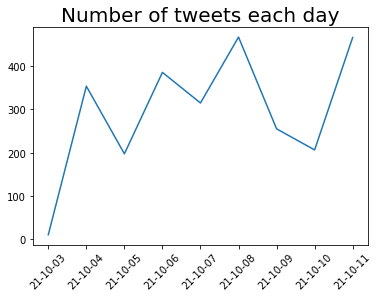

In [201]:
# counts of tweets: have data for about a week
df['day'] = df['created_at'].dt.strftime('%y-%m-%d')
df['hour'] = df['created_at'].dt.hour
ax = df.day.value_counts().sort_index().plot()
ax.set_title('Number of tweets each day', fontsize=20)  
plt.setp(ax.get_xticklabels(), rotation = 45)
plt.show()

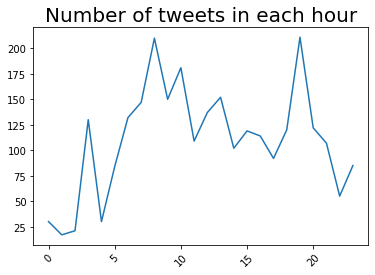

In [202]:
ax = df.hour.value_counts().sort_index().plot()
ax.set_title('Number of tweets in each hour', fontsize=20)  
plt.setp(ax.get_xticklabels(), rotation = 45)
plt.show()

In [203]:
# counting keywords in each 
keywords = ["queue","line","wait"]
for keyword in keywords:
    df[keyword] = df['text'].apply(lambda _str: _str.lower().count(keyword))
    
df['wait_keywords_count'] = df[keywords].sum(axis=1) 
df['wait_keywords_any'] = df['wait_keywords_count'] >= 1

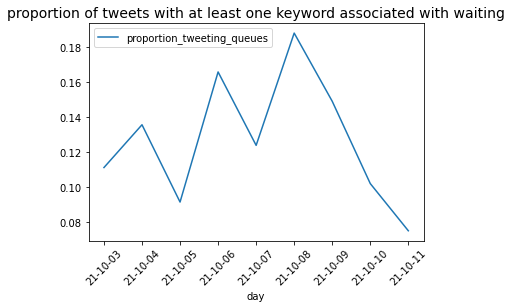

In [204]:
# looking at proportion of tweets with at least one keyword
tweets_with_keyword_daily = df.groupby(['day']).wait_keywords_any.sum()
total_tweets_daily = df.groupby(['day']).count().iloc[:, 1]

daily_trends = pd.concat([tweets_with_keyword_daily,total_tweets_daily],axis=1)
daily_trends['proportion_tweeting_queues'] = daily_trends.wait_keywords_any / daily_trends.favourite_count

daily_trends.reset_index(drop=False, inplace=True)
ax = daily_trends.plot(x = 'day', y = 'proportion_tweeting_queues')
ax.set_title('proportion of tweets with at least one keyword associated with waiting', fontsize=14)  
plt.setp(ax.get_xticklabels(), rotation = 45)
plt.show()

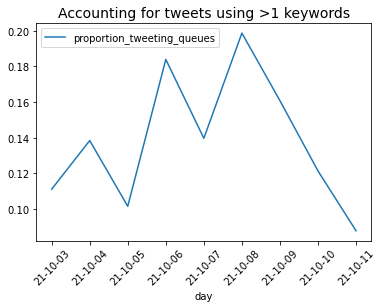

In [205]:
# looking at rate of keywords divided by total tweets
# subtly different to the above in that it captures >1 use of keyword. trend looks almost identical
tweets_with_keyword_daily = df.groupby(['day']).wait_keywords_count.sum()
total_keywords_daily = df.groupby(['day']).count().iloc[:,1]

daily_trends = pd.concat([tweets_with_keyword_daily,total_keywords_daily],axis=1)
daily_trends['proportion_tweeting_queues'] = daily_trends.wait_keywords_count / daily_trends.favourite_count

daily_trends.reset_index(drop=False, inplace=True)
ax = daily_trends.plot(x = 'day', y = 'proportion_tweeting_queues')
ax.set_title('Accounting for tweets using >1 keywords', fontsize=14)  
plt.setp(ax.get_xticklabels(), rotation = 45)
plt.show()

Text(0.5, 1.0, 'Total tweets with at least one keyword. Not adjusting for total tweets')

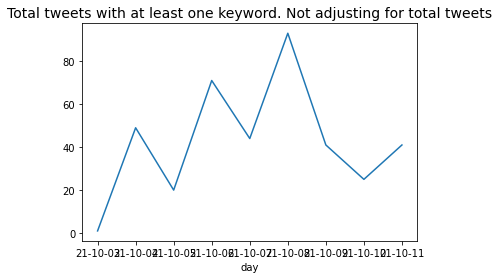

In [206]:
ax = df.groupby(['day']).wait_keywords_count.sum().plot()
ax.set_title('Total tweets with at least one keyword. Not adjusting for total tweets', fontsize=14)  

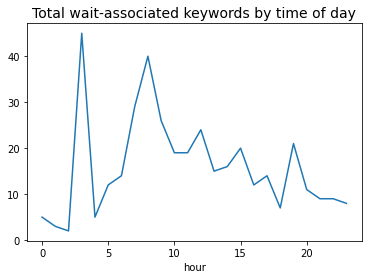

In [207]:
ax = df.groupby(['hour']).wait_keywords_count.sum().plot()
ax.set_title('Total wait-associated keywords by time of day', fontsize=14)  
plt.show()

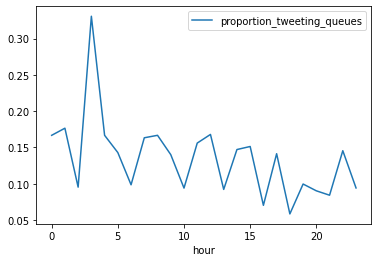

In [208]:
tweets_with_keyword_daily = df.groupby(['hour']).wait_keywords_any.sum()
total_tweets_daily = df.groupby(['hour']).count().iloc[:, 1]

daily_trends = pd.concat([tweets_with_keyword_daily,total_tweets_daily],axis=1)
daily_trends['proportion_tweeting_queues'] = daily_trends.wait_keywords_any / daily_trends.favourite_count

daily_trends.reset_index(drop=False, inplace=True)
daily_trends.plot(x = 'hour', y = 'proportion_tweeting_queues')
ax.set_title('Tweet-volume adjusted inputs by time of day', fontsize=14)  
plt.show()

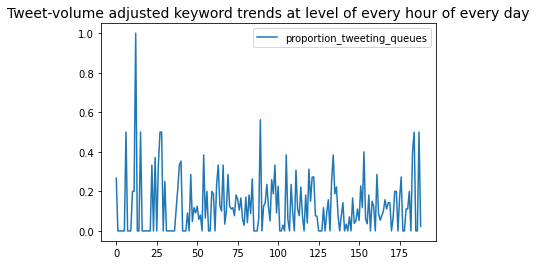

In [209]:
tweets_with_keyword_daily = df.groupby(['hour', 'day']).wait_keywords_any.sum()
total_tweets_daily = df.groupby(['hour', 'day']).count().iloc[:, 1]

daily_trends = pd.concat([tweets_with_keyword_daily,total_tweets_daily],axis=1)
daily_trends['proportion_tweeting_queues'] = daily_trends.wait_keywords_any / daily_trends.favourite_count

daily_trends.reset_index(drop=False, inplace=True)
ax = daily_trends.plot(y = 'proportion_tweeting_queues')              
ax.set_title('Tweet-volume adjusted keyword trends at level of every hour of every day', fontsize=14)  
plt.show()

In [210]:
# getting sentiments (polarity [1=positive;-1=negative] and subjectivity) by the hour
df['sentiment'] = df['text'].apply(lambda tweet: TextBlob(tweet).sentiment)
df.loc[:,'polarity']=df.sentiment.map(lambda x:x[0])
df.loc[:,'subjectivity']=df.sentiment.map(lambda x:x[1])
df.drop(columns=['sentiment'], inplace=True)

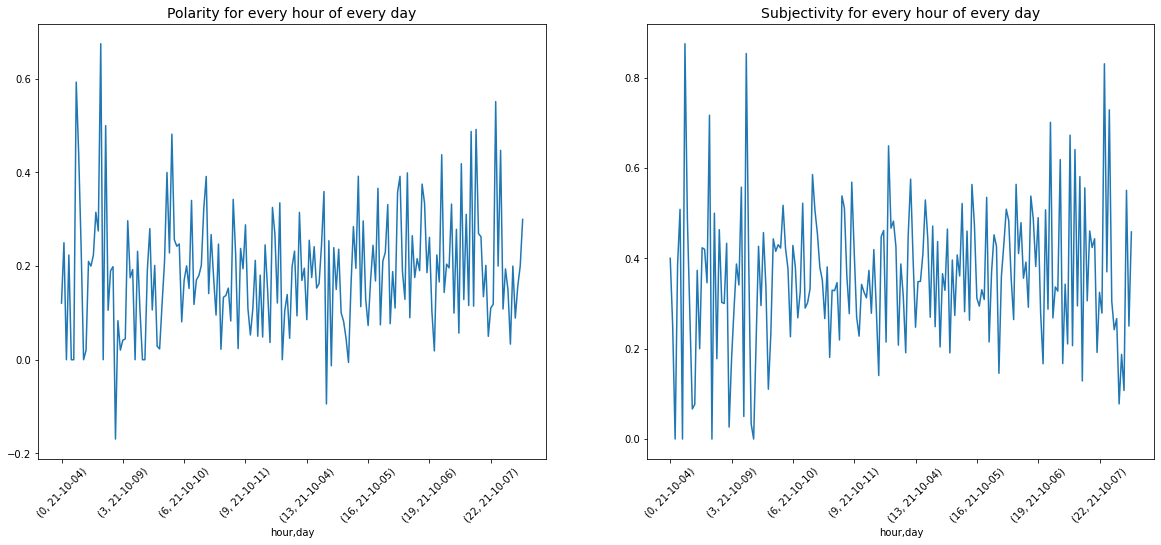

In [214]:
# plot polarity and subjectivity
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
df.groupby(['hour', 'day']).polarity.mean().plot(ax=ax1)
df.groupby(['hour', 'day']).subjectivity.mean().plot(ax=ax2)
ax1.set_title('Polarity for every hour of every day', fontsize=14)  
ax2.set_title('Subjectivity for every hour of every day', fontsize=14)  
plt.setp(ax1.get_xticklabels(), rotation = 45)
plt.setp(ax2.get_xticklabels(), rotation = 45)
plt.show()

In [212]:
# correlation between twitter sentiments and tweets with and without keywords
columns_for_correlation = ['polarity', 'subjectivity', 'wait_keywords_count']
df[columns_for_correlation].corr()


,polarity,subjectivity,wait_keywords_count
polarity,1.000000,0.615297,-0.129972
subjectivity,0.615297,1.000000,-0.063044
wait_keywords_count,-0.129972,-0.063044,1.000000
